In [10]:
import pandas as pd
from sys import argv
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Wczytuje dane z pliku Excel, zakładając, że arkusze są odpowiednio nazwane.
def load_data(file_path):
    """
    Załaduj dane z pliku Excela.
    file_path: str - ścieżka do pliku Excel.
    Zwraca: Xt (cechy treningowe), Yt (etykiety treningowe),
            Xv (cechy testowe), Yv (etykiety testowe).
    """
    Xt, Xv = pd.read_excel(file_path, sheet_name='X_train'), pd.read_excel(file_path, sheet_name='X_test')
    Yt, Yv = pd.read_excel(file_path, sheet_name='y_train'), pd.read_excel(file_path, sheet_name='y_test')
    return Xt, Yt, Xv, Yv

In [12]:
# Przygotowuje dane przez autoskalowanie cech i zwraca gotowe zbiory danych.
def prepare_data(Xt, Yt, Xv, Yv):
    """
    Przekształca dane przez autoskalowanie (tylko cechy).
    Xt, Xv: DataFrame - cechy treningowe i testowe.
    Yt, Yv: DataFrame - etykiety treningowe i testowe.
    Zwraca: przeskalowane Xt i Xv oraz równo wymiarowe wektory Yt i Yv.
    """
    # Tworzymy obiekt StandardScaler do normalizacji danych wejściowych (cech).
    scaler = StandardScaler()

    Xv = Xv.rename(columns={'qc': 'qc-'})
    Xt = Xt.rename(columns={'qc': 'qc-'})

    X_train_scaled = scaler.fit_transform(Xt)  # Dopasowanie i transformacja danych treningowych.
    X_test_scaled = scaler.fit_transform(Xv)      # Transformacja danych testowych na podstawie treningowych.

    # Zwracamy przeskalowane dane oraz równo wymiarowe etykiety.
    return X_train_scaled, X_test_scaled, Yt.values.ravel(), Yv.values.ravel()

In [13]:
from math import nan
# Wybiera optymalną wartość k na podstawie RMSE i walidacji krzyżowej.
def find_optimal_k(X_train, y_train, max_k=-1, n_splits = 6):
    """
    Znajdź optymalne k dla modelu KNN za pomocą walidacji krzyżowej.
    X_train: ndarray - przeskalowane dane treningowe.
    y_train: ndarray - etykiety treningowe.
    max_k: int - maksymalna liczba sąsiadów do sprawdzenia.
    Zwraca: najlepsze k oraz wykres zależności k od RMSE.
    """
    if max_k == -1:
      max_k = X_train.shape[0]

    cv = KFold(n_splits=4, shuffle=True, random_state=1)  # Ustawiamy 5 podziałów dla CV.
    rmse_values = []  # Lista do przechowywania wyników RMSE dla różnych wartości k.
    k_values = []

    k = 1
    rmse = 0
    # Iterujemy po wartościach k od 1 do max_k.
    while k <= max_k:
        knn = KNeighborsRegressor(n_neighbors=k)  # Tworzymy model KNN dla danego k.
        # Obliczamy negatywną średnią wartość RMSE przez walidację krzyżową.
        scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        rmse = np.sqrt(-scores.mean())  # RMSE jako pierwiastek z negatywnego MSE.
        if rmse > 0:
          print(f"k={k}, RMSE={rmse}")
          rmse_values.append(rmse)
          k_values.append(k)
          k += 1
        elif ValueError:
          break
        else:
          break

    # Znajdź k, które minimalizuje RMSE.
    optimal_k = np.argmin(rmse_values) + 1
    print(rmse_values, sep='\n')

    # Wykres zależności k od RMSE.
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, rmse_values, marker='o', linestyle='--', color='b')
    plt.xlabel('Liczba sąsiadów (k)')
    plt.ylabel('RMSE')
    plt.title('Zależność liczby sąsiadów (k) od RMSE')
    plt.xticks(k_values)
    plt.grid()
    plt.show()

    return optimal_k

In [14]:
# Trenuje model KNN na podanych danych treningowych.
def train_knn(X_train, y_train, n_neighbors=5):
    """
    Tworzy i trenuje klasyfikator KNN.
    X_train: ndarray - przeskalowane dane treningowe.
    y_train: ndarray - etykiety treningowe.
    n_neighbors: int - liczba sąsiadów (domyślnie 5).
    Zwraca: wytrenowany model KNN.
    """
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)  # Inicjalizacja modelu KNN.
    knn.fit(X_train, y_train)  # Dopasowanie modelu do danych treningowych.
    return knn

In [15]:
# Wylicza statystyki R², RMSE, Q² i RMSEex.
def calculate_statistics(y_true, y_pred):
    """
    Oblicza statystyki R², RMSE oraz wykreśla wykres y_pred vs y_true.
    y_true: ndarray - rzeczywiste etykiety.
    y_pred: ndarray - przewidywane etykiety.
    Zwraca: None (wyświetla wykres i wypisuje statystyki).
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Wyliczenie RMSE.
    r2 = r2_score(y_true, y_pred)  # Wyliczenie współczynnika determinacji R².

    print(f'R²: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')

    return r2, rmse

In [16]:
def my_reg(y_true):
  slope, intercept, r, p, std_err = stats.linregress(y_true, y_pred)
  return slope * y_true + intercept

def y_vec_plot(y_true, y_pred):

    reg = list(map(my_reg, y_true))
    # Wykres y_pred vs y_true.
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot(y_true, reg, linestyle='--', color='red')
    plt.xlabel('Rzeczywiste y')
    plt.ylabel('Przewidywane y')
    plt.title('Zależność y_pred od y_true')
    plt.grid()
    plt.show()



In [17]:
def statistica(y_true, y_pred):
    """
    Oblicza statystyki R², RMSE oraz wykreśla wykres y_pred vs y_true.
    y_true: ndarray - rzeczywiste etykiety.
    y_pred: ndarray - przewidywane etykiety.
    Zwraca: None (wyświetla wykres i wypisuje statystyki).
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Wyliczenie RMSE.
    r2 = r2_score(y_true, y_pred)  # Wyliczenie współczynnika determinacji R².

    # Wykres y_pred vs y_true.
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red')
    plt.xlabel('Rzeczywiste y')
    plt.ylabel('Przewidywane y')
    plt.title('Zależność y_pred od y_true')
    plt.grid()
    plt.show()

    print(f'R²: {r2:.4f}')
    print(f'RMSE: {rmse:.4f}')

k=1, RMSE=0.28336433114749404
k=2, RMSE=0.285747307657191
k=3, RMSE=0.2467806325876696
k=4, RMSE=0.22924421650738178
k=5, RMSE=0.25257529993383493
k=6, RMSE=0.26643366082454817
k=7, RMSE=0.2857324589488194
k=8, RMSE=0.3184273221365794
k=9, RMSE=0.3287846602189152
k=10, RMSE=0.34722218190710874
k=11, RMSE=0.3734693227386415
k=12, RMSE=0.40036204691136773
k=13, RMSE=0.41074592827402245
k=14, RMSE=0.4326600860121734
k=15, RMSE=0.4507404935017734
k=16, RMSE=0.4858421719558536
k=17, RMSE=0.5178081529113396
[0.28336433114749404, 0.285747307657191, 0.2467806325876696, 0.22924421650738178, 0.25257529993383493, 0.26643366082454817, 0.2857324589488194, 0.3184273221365794, 0.3287846602189152, 0.34722218190710874, 0.3734693227386415, 0.40036204691136773, 0.41074592827402245, 0.4326600860121734, 0.4507404935017734, 0.4858421719558536, 0.5178081529113396]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_regression.py", line 243, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/usr/local/lib/python3.10/dist-packages

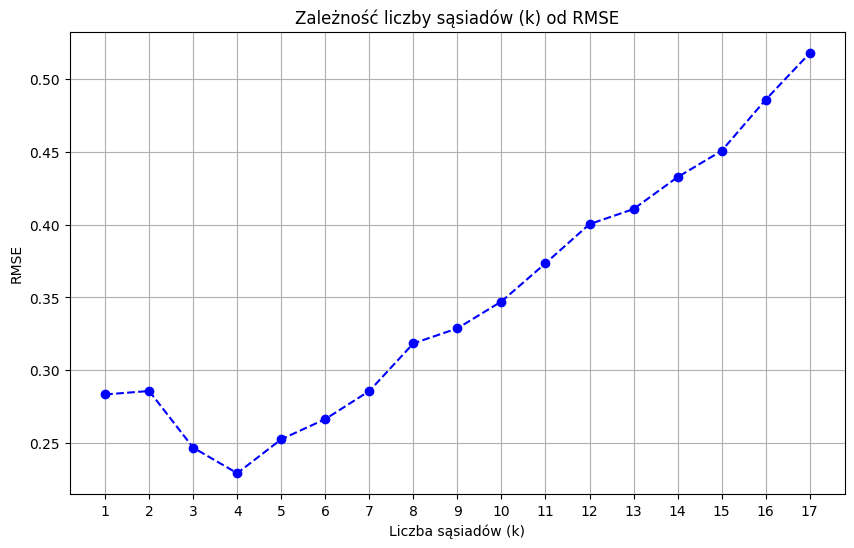

Optymalna liczba sąsiadów (k): 4


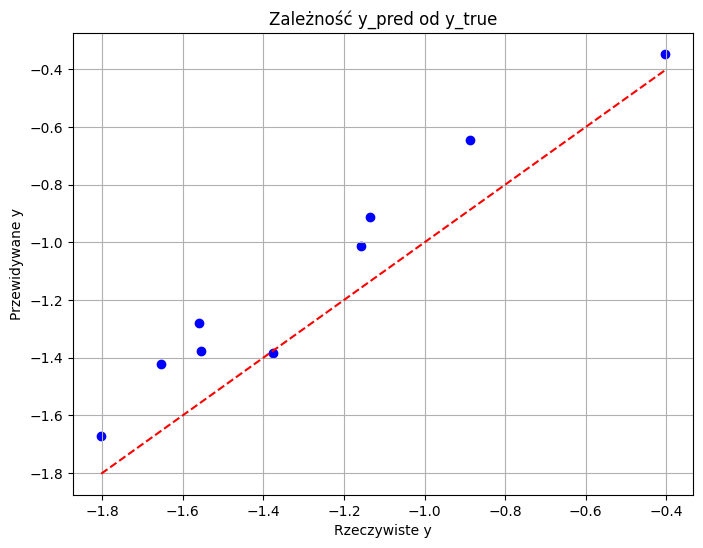

R²: 0.7953
RMSE: 0.1867


In [18]:
# Blok główny programu.
if __name__ == "__main__":
    # Podaj ścieżkę do pliku Excela jako argument przy uruchamianiu skryptu.
    file_path = '/content/ftalany.xlsx'  # Pobranie ścieżki do pliku z argumentu wiersza poleceń.

    # Wczytaj dane z pliku.
    Xt, Yt, Xv, Yv = load_data(file_path)

    # Przygotuj dane (autoskalowanie cech).
    X_train, X_test, y_train, y_test = prepare_data(Xt, Yt, Xv, Yv)

    # Znajdź optymalną wartość k.
    optimal_k = find_optimal_k(X_train, y_train)
    print(f"Optymalna liczba sąsiadów (k): {optimal_k}")

    # Trenuj model KNN z optymalnym k.
    knn_model = train_knn(X_train, y_train, n_neighbors=optimal_k)

    # Przewidywanie wyników na zbiorze testowym.
    y_pred = knn_model.predict(X_test)

    # Obliczanie statystyk i wyświetlenie wykresu.
    #calculate_statistics(y_test, y_pred)
    statistica(y_test, y_pred)
    #y_vec_plot(y_test, y_pred)

In [19]:
slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

NameError: name 'x' is not defined